In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
%reload_ext autoreload

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob

import h5py
import flammkuchen as fl
import seaborn as sns
from matplotlib.cm import ScalarMappable
import scipy
from scipy import stats
from tqdm import tqdm

In [4]:
from skimage.filters import threshold_otsu

def extract_extrema(arr): 
    """Extract indices where extrema are found in a tail or fin trace.

    :param arr: tail of fin trace
    :return: list of indices where minima and maxima are found.
    """

    idxs = np.arange(arr.shape[0])

    min_idxs = []
    max_idxs = []

    for i in range(1, arr.shape[0] - 1):
        if arr[i - 1] < arr[i] > arr[i + 1]:
            max_idxs.append(i)
        elif arr[i - 1] > arr[i] < arr[i + 1]:
            min_idxs.append(i)

    return min_idxs, max_idxs
    
    
def moving_average(a, n=2):
    """Compute rolling average on a given array.

    :param a: array
    :param n: size of rolling window
    :return: new array
    """

    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def compute_tbf(traces, extract_extrema, moving_average, dt=1.0, threshold=0.2, min_valid_tps=5):
    """
    Computes the TBF (time between features) for each trace based on extrema.

    Parameters:
    - traces: The 3D numpy array containing the traces to analyze.
    - extract_extrema: A function that returns the minima and maxima of a trace.
    - moving_average: A function that calculates the moving average of an array.
    - dt: Time step duration (default is 1.0).
    - threshold: The threshold for considering significant extrema changes (default is 0.2).
    - min_valid_tps: Minimum number of time points required for valid TBF computation (default is 5).

    Returns:
    - tbf_output: The computed TBF values for the input traces.
    """
    tbf_output_list = []

    for fin in range(traces.shape[1]):
        extrema_idxs = []

        for trace in traces[:, fin, :]:
            # Identify extrema
            mins, maxs = extract_extrema(trace)
            
            # Combine and sort indexes, add first and last timepoints
            extrema = np.sort(np.concatenate((np.array(mins), np.array(maxs))))
            extrema = np.insert(extrema, 0, 0)
            extrema = np.append(extrema, trace.shape[-1] - 1)

            # Normalize trace and compute average difference for each extrema
            trace_norm = (trace - trace.min()) / (trace.max() - trace.min())
            extrema_y = [trace_norm[i] for i in extrema]
            extrema_diff = np.abs(np.diff(extrema_y))
            avg_extrema_diff = moving_average(extrema_diff)

            # Append extrema if their average change is larger than the threshold
            extrema_idxs.append(extrema[1:-1][avg_extrema_diff > threshold])

        # Compute TBFs
        idxs = np.arange(traces.shape[2])
        tbf_output = np.full((traces.shape[0], idxs.shape[0]), np.nan)

        for i, extrema in enumerate(extrema_idxs):
            if len(extrema) > 1:  # To avoid issues with min() and max() on empty arrays
                valid_idxs = idxs[np.logical_and(idxs >= min(extrema), idxs < max(extrema))]

                if len(valid_idxs) > min_valid_tps:
                    time_diffs = np.diff(extrema) * dt
                    binned_tps = np.digitize(valid_idxs, extrema) - 1
                    instant_time_diff = np.array([time_diffs[i] for i in binned_tps])
                    tbf = (1 / instant_time_diff) / 2
                    tbf_output[i, valid_idxs[0]:valid_idxs[-1] + 1] = tbf

        tbf_output_list.append(tbf_output)

    return np.stack(tbf_output_list)

In [5]:
def combine_and_sort_indices(peaks_i_array, valleys_i_array):
    """
    Combines and sorts peaks and valleys indices for each row, ignoring NaNs.
    
    Parameters:
    - peaks_i_array: 2D numpy array of peaks indices.
    - valleys_i_array: 2D numpy array of valleys indices.
    
    Returns:
    - sorted_indices_array: 2D numpy array with sorted indices for each row.
    """
    num_rows, num_cols = peaks_i_array.shape
    sorted_indices_array = np.full((num_rows, num_cols * 2), np.nan, dtype=float)

    for row in range(num_rows):
        # Combine peaks and valleys, ignoring NaNs
        combined_indices = np.concatenate((peaks_i_array[row], valleys_i_array[row]))
        valid_indices = combined_indices[~np.isnan(combined_indices)].astype(int)
        
        # Sort the combined indices
        sorted_indices = np.sort(valid_indices)
        
        # Store the sorted indices in the output array
        sorted_indices_array[row, :len(sorted_indices)] = sorted_indices

    return sorted_indices_array

def calculate_periods_between_peaks(peaks_i_array, fps):
    """
    Calculates the periods (in seconds) between peaks for each row in the peaks_i_array, 
    maintaining the original shape of the array.
    
    Parameters:
    - peaks_i_array: 2D numpy array where each row contains indices of peaks.
    - fps: Frames per second of the sampling rate.
    
    Returns:
    - periods_array: 2D numpy array with the same shape as peaks_i_array, where each row
      contains the periods between successive peaks, and remaining positions are NaN.
    """
    num_rows, num_cols = peaks_i_array.shape
    periods_array = np.full((num_rows, num_cols), np.nan, dtype=float)

    for row in range(num_rows):
        peak_indices = peaks_i_array[row]
        # Remove NaN values and convert to integers
        valid_indices = peak_indices[~np.isnan(peak_indices)].astype(int)

        # Calculate the differences between successive peak indices
        if len(valid_indices) > 1:
            frame_differences = np.diff(valid_indices)
            # Convert frame differences to time periods in seconds
            periods = frame_differences / fps
            # Copy periods to the corresponding row in the output array
            periods_array[row, :len(periods)] = periods

    return periods_array

In [6]:
from skimage.filters import threshold_otsu
from scipy.signal import savgol_filter

def extract_extrema(arr):    
    idxs = np.arange(arr.shape[0])
    min_idxs = []
    max_idxs = []
    for i in range(1, arr.shape[0] - 1):
        if arr[i - 1] < arr[i] > arr[i + 1]:
            max_idxs.append(i)
        elif arr[i - 1] > arr[i] < arr[i + 1]:
            min_idxs.append(i)
    return min_idxs, max_idxs
    
def moving_average(a, n=2):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def smooth_trace(trace, wnd=9, poly=2):
    return savgol_filter(trace, wnd, poly)  # window size 5, polynomial order 2

def find_extrema_and_peaks(data, thr=.1):
    extrema_idxs = []
    extrema_diffs = []

    for trace in data:
        # Identify extrema
        mins, maxs = extract_extrema(trace)

        # Combine, sort, and add indexes for first and last timepoints (needed to compute all needed differentials)
        extrema = np.sort(np.concatenate((np.array(mins), np.array(maxs))))
        extrema = np.insert(extrema, 0, 0)
        extrema = np.append(extrema, trace.shape[-1]-1)

        # Normalize trace to [0,1] range and compute average diff (before and after) for each extrema
        trace_norm = (trace-trace.min())/(trace.max()-trace.min())
        extrema_y = [trace_norm[i] for i in extrema]
        extrema_diff = np.abs(np.diff(extrema_y))
        avg_extrema_diff = moving_average(extrema_diff)

        # Append values
        extrema_idxs.append(extrema)
        extrema_diffs.append(avg_extrema_diff)

    # Find Otsu threshold for extrema inclusion
    # thr = threshold_otsu(np.concatenate(extrema_diffs))

    # Identify real extrema
    real_extrema = [bout > thr for bout in extrema_diffs]

    # Recapitulate positions and amplitudes for all extrema
    real_extrema_idxs = [extrema_idxs[bout][1:-1][real_extrema[bout]] for bout in range(len(real_extrema))]
    real_extrema_diff = [[np.diff(data[bout])[i] for i in real_extrema_idxs[bout]] for bout in range(len(real_extrema))]

    peaks_i = [real_extrema_idxs[bout][np.array(real_extrema_diff[bout]) < 0] for bout in range(len(real_extrema))]
    peaks_a = [[data[bout, i] for i in peaks_i[bout]] for bout in range(len(real_extrema))]

    valleys_i = [real_extrema_idxs[bout][np.array(real_extrema_diff[bout]) > 0] for bout in range(len(real_extrema))]
    valleys_a = [[data[bout, i] for i in valleys_i[bout]] for bout in range(len(real_extrema))]
    
    return peaks_a, peaks_i, valleys_a, valleys_i


def extract_peaks_valleys_arrays(data, peaks_a, peaks_i, valleys_a, valleys_i, max_n=9):
    """
    Function to extract and fill arrays for peaks and valleys.

    Parameters:
    - data: numpy.ndarray, the original data array from which peaks and valleys are derived.
    - peaks_a: list of lists, amplitudes of peaks for each trace.
    - peaks_i: list of lists, indices of peaks for each trace.
    - valleys_a: list of lists, amplitudes of valleys for each trace.
    - valleys_i: list of lists, indices of valleys for each trace.
    - max_n: int, maximum number of peaks/valleys to store for each trace (default is 9).

    Returns:
    - peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array: numpy.ndarrays filled with peak/valley data.
    """
    num_traces = data.shape[0]
    
    # Initialize arrays with NaN
    peaks_a_array = np.full((num_traces, max_n), np.nan)
    peaks_i_array = np.full((num_traces, max_n), np.nan)
    valleys_a_array = np.full((num_traces, max_n), np.nan)
    valleys_i_array = np.full((num_traces, max_n), np.nan)

    # Fill arrays with peak and valley data
    for i in range(num_traces):
        peak_count = min(len(peaks_a[i]), max_n)
        valley_count = min(len(valleys_a[i]), max_n)
        
        peaks_a_array[i, :peak_count] = peaks_a[i][:peak_count]
        peaks_i_array[i, :peak_count] = peaks_i[i][:peak_count]
        valleys_a_array[i, :valley_count] = valleys_a[i][:valley_count]
        valleys_i_array[i, :valley_count] = valleys_i[i][:valley_count]
    
    return peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array


In [7]:
def reshape_feature_array(feature_vector_array):
    """
    Reshape the feature vector array into a specified shape and extract sub-arrays.

    Parameters:
    - feature_vector_array: numpy.ndarray, the array to be reshaped.

    Returns:
    - reshaped_array: numpy.ndarray, the reshaped array.
    - peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array: separate sub-arrays.
    """
    max_n = int(feature_vector_array.shape[1] / 4)

    # Reshape the array
    reshaped_array = feature_vector_array.reshape(feature_vector_array.shape[0], 4, max_n)

    # Extract sub-arrays
    peaks_a_array = reshaped_array[:, 0, :]
    peaks_i_array = reshaped_array[:, 1, :]
    valleys_a_array = reshaped_array[:, 2, :]
    valleys_i_array = reshaped_array[:, 3, :]

    print(f"Reshaped array shape: {reshaped_array.shape}")

    return reshaped_array, peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array

In [28]:
## make all tails positive

def invert_tail(tail, lat):
    # Create a copy of the traces to keep the original unchanged
    new_tail = np.copy(tail)

    for i, dir_value in enumerate(lat):
        if dir_value == 1:  # left
            new_tail[i] = tail[i, :]
        elif dir_value == -1: #right 
            new_tail[i] = tail[i, :]*-1
    return new_tail


In [8]:
sns.set_theme(style="white", palette="pastel")

## Load data

In [55]:
master_path = Path(r'\\portulab.synology.me\data\Kata\Processed_Data\tensor_data')
# master_path = Path(r'/Users/katharinakotter/Desktop/Processed_Data/tensor_data')

# path_tensors = Path(master_path/ 'tensor_ipsi_contra_f.h5')
path_tensors = Path(master_path/ 'tensor_ipsi_contra_pos.h5')
path_features = Path(master_path/ 'features_bouts_new_f.csv')
master_path, path_tensors, path_features

(WindowsPath('//portulab.synology.me/data/Kata/Processed_Data/tensor_data'),
 WindowsPath('//portulab.synology.me/data/Kata/Processed_Data/tensor_data/tensor_ipsi_contra_pos.h5'),
 WindowsPath('//portulab.synology.me/data/Kata/Processed_Data/tensor_data/features_bouts_new_f.csv'))

### Invert all fins and make tails postive

In [60]:
features = pd.read_csv(path_features)
data = fl.load(path_tensors)
print(data.shape)

## specify 0 for tail, 1 for l fin and 2 for right fin
## because we dont want to confuse peaks and vallyes later -> left invert l fin
data_tail_ = data[:,0,:]
data_l_fin_ = data[:,1,:]
data_r_fin_ = data[:,2,:]

(13779, 3, 50)


In [61]:
laterality  = features.tail_direction.values
i_c = features.ipsi_fin.values

In [62]:
data_tail = invert_tail(data_tail_, laterality)
data_tail.shape

(13779, 50)

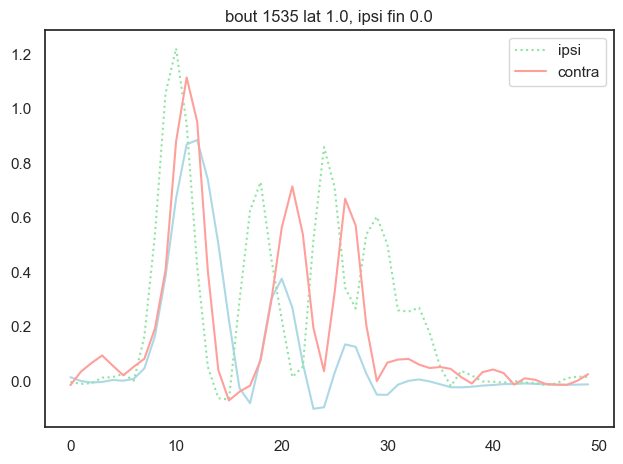

In [67]:
bout = np.random.randint(0, data_tail_.shape[0])

plt.figure()
plt.title(f'bout {bout} lat {laterality[bout]}, ipsi fin {features.ipsi_fin.iloc[bout]}')

plt.plot(data_tail[bout, :].T, c='lightblue')
plt.plot(data_l_fin_[bout,:], label='ipsi', ls=':', c='g')
plt.plot(data_r_fin_[bout,:], label='contra', c='r')
plt.legend()

plt.tight_layout()

## Load traces and make tensor in shape (trials, tails, left fin, right fin)

In [87]:

datas = [data_tail, data_l_fin_, data_r_fin_]
feat_array_lists = []

for data_ in datas:
    # data = np.apply_along_axis(smooth_trace, 1, data_)
    peaks_a, peaks_i, valleys_a, valleys_i = find_extrema_and_peaks(data_, thr=.2)

    peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array = extract_peaks_valleys_arrays(data_, peaks_a, peaks_i, valleys_a, valleys_i, max_n=9)
    # concatenate feature array
    feature_vector_array = np.concatenate([peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array], axis=1)
    feat_array_lists.append(feature_vector_array)
    
fl.save(master_path/'peaks_valleys'/ 't_feature_vector_array.h5', feat_array_lists[0])
fl.save(master_path/'peaks_valleys'/ 'l_feature_vector_array.h5', feat_array_lists[1])
fl.save(master_path/'peaks_valleys'/ 'r_feature_vector_array.h5', feat_array_lists[2])

    

In [88]:
master_path

WindowsPath('//portulab.synology.me/data/Kata/Processed_Data/tensor_data')

In [89]:
t_reshaped_array, t_peaks_a_array, t_peaks_i_array, t_valleys_a_array, t_valleys_i_array = reshape_feature_array(feat_array_lists[0])
l_reshaped_array, l_peaks_a_array, l_peaks_i_array, l_valleys_a_array, l_valleys_i_array = reshape_feature_array(feat_array_lists[1])
r_reshaped_array, r_peaks_a_array, r_peaks_i_array, r_valleys_a_array, r_valleys_i_array = reshape_feature_array(feat_array_lists[2])
l_peaks_a_array.shape 

Reshaped array shape: (13779, 4, 9)
Reshaped array shape: (13779, 4, 9)
Reshaped array shape: (13779, 4, 9)


(13779, 9)

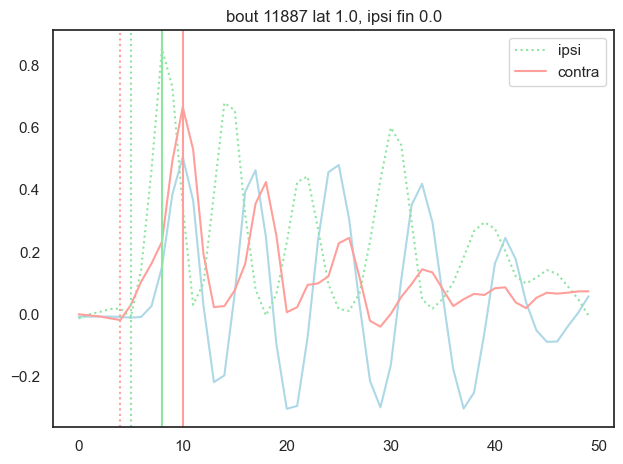

In [96]:
bout = np.random.randint(0, data_tail_.shape[0])

plt.figure()
plt.title(f'bout {bout} lat {laterality[bout]}, ipsi fin {features.ipsi_fin.iloc[bout]}')

plt.plot(data_tail[bout, :].T, c='lightblue')
plt.plot(data_l_fin_[bout,:], label='ipsi', ls=':', c='g')
plt.plot(data_r_fin_[bout,:], label='contra', c='r')

plt.axvline(l_peaks_i_array[bout,0], c='g')
plt.axvline(l_valleys_i_array[bout, 0], ls=':', c='g')

plt.axvline(r_peaks_i_array[bout,0], c='r')
plt.axvline(r_valleys_i_array[bout, 0], ls=':', c='r')

plt.legend()

plt.tight_layout()

In [97]:
fps=200

In [98]:
periods_array = calculate_periods_between_peaks(t_peaks_i_array, fps)
sorted_indices_array = combine_and_sort_indices(t_peaks_i_array, t_valleys_i_array)
half_beats_array = calculate_periods_between_peaks(sorted_indices_array, fps)
fl.save(master_path/'peaks_valleys'/ 't_full_beats.h5', periods_array)
fl.save(master_path/'peaks_valleys'/ 't_half_beats.h5', half_beats_array)

periods_array = calculate_periods_between_peaks(l_peaks_i_array, fps)
sorted_indices_array = combine_and_sort_indices(l_peaks_i_array, l_valleys_i_array)
half_beats_array = calculate_periods_between_peaks(sorted_indices_array, fps)
fl.save(master_path/'peaks_valleys'/ 'l_full_beats.h5', periods_array)
fl.save(master_path/'peaks_valleys'/ 'l_half_beats.h5', half_beats_array)

periods_array = calculate_periods_between_peaks(r_peaks_i_array, fps)
sorted_indices_array = combine_and_sort_indices(r_peaks_i_array, r_valleys_i_array)
half_beats_array = calculate_periods_between_peaks(sorted_indices_array, fps)
fl.save(master_path/'peaks_valleys'/ 'r_full_beats.h5', periods_array)
fl.save(master_path/'peaks_valleys'/ 'r_half_beats.h5', half_beats_array)
    

In [99]:
tbf_result = compute_tbf(data, extract_extrema, moving_average)
print (tbf_result.shape)
fl.save(master_path/'peaks_valleys'/ 'tbf_output.h5', tbf_result)

(3, 13779, 50)
